In [1]:
import json
from glob import glob
import os
import multiprocessing as mp
from time import time

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from rdkit.Chem.AllChem import ReactionFromSmarts
from rdkit.Chem import CanonSmiles

from ord_data_load import df_na_vals, parse_pb_file
from ord_data_load import ORD_PATH, ORD_REPO_PATH

%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

## Datasets of interest

#TODO treat those datasets separately

750 Buchwald-Hartwig reactions generated from AstraZeneca ELN which is used in yield prediction work
*"Graph Neural Networks for Predicting Chemical Reaction Performance"*
[https://doi.org/10.26434/chemrxiv.14589498.v2](https://doi.org/10.26434/chemrxiv.14589498.v2)
[ord_dataset-00005539a1e04c809a9a78647bea649c](https://open-reaction-database.org/client/search?dataset_ids=ord_dataset-00005539a1e04c809a9a78647bea649c)


1536 reactions using HTS with Pd cat. Good quality quantitative data.
*"Nanomole-scale high-throughput chemistry for the synthesis of complex molecules"*
[https://doi.org/10.1126/science.1259203](https://doi.org/10.1126/science.1259203)
```ord_dataset-7d8f5fd922d4497d91cb81489b052746```


5760 Suzuki reactions. Quantitative data. Single scaffold
*A platform for automated nanomole-scale reaction screening and micromole-scale synthesis in flow*
[https://doi.org/10.1126/science.aap9112](https://doi.org/10.1126/science.aap9112)
```ord_dataset-68cb8b4b2b384e3d85b5b1efae58b203```


4312 C-N cross-coupling reactions. Quantitative data. Single scaffold.
Different heterocycles - B, Si etc.
*"Predicting reaction performance in C–N cross-coupling using machine learning"*
[https://doi.org/10.1126/science.aar5169](https://doi.org/10.1126/science.aar5169)
```ord_dataset-46ff9a32d9e04016b9380b1b1ef949c3```


450 Pd/Ni cat reactions. Might be usable
*"Linking Mechanistic Analysis of Catalytic Reactivity Cliffs to Ligand Classification"*
[https://doi.org/10.26434/chemrxiv.14388557.v1](https://doi.org/10.26434/chemrxiv.14388557.v1)
```ord_dataset-3b5db90e337942ea886b8f5bc5e3aa72```

376 Suzuki reactions. Quantitative data.
```ord_dataset-eeba974d3c284aed86d1c1d442260a1e```

288 Buchwald reactions. Quantitative data. Single reaction
```ord_dataset-cbcc4048add7468e850b6ec42549c70d```

256 Suzuki reactions. Quantitative data.
[https://doi.org/10.1039/c5sc04751j](https://doi.org/10.1039/c5sc04751j)
```ord_dataset-0c75d67751634f0594b24b9f498b77c2```


500k reactions. Split to train and test. Different reaction classes
*"A graph-convolutional neural network model for the prediction of chemical reactivity"*
[https://doi.org/10.1039/C8SC04228D](https://doi.org/10.1039/C8SC04228D)
```
ord_dataset-de0979205c84441190feef587fef8d6d
ord_dataset-488402f6ec0d441ca2f7d6fabea7c220
ord_dataset-5481550056a14935b76e031fb94b88be
```

1728 low variability data.
*Nano CN PhotoChemistry Informers Library*
```ord_dataset-ac78456835404910b3a4c840248b6ac9```


https://doi.org/10.1038/s41586-021-03213-y
1728 quantitative data. Low variability.
```ord_dataset-d26118acda314269becc35db5c22dc59```




## Load and clean data

In [137]:
#TODO load those files ~ 500k reactions from https://doi.org/10.1039/C8SC04228D
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*de0979205c84441190feef587fef8d6d.pb.gz')[0], ORD_PATH)
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*488402f6ec0d441ca2f7d6fabea7c220.pb.gz')[0], ORD_PATH)
# parse_pb_file(glob(f'{ORD_REPO_PATH}/data/*/*5481550056a14935b76e031fb94b88be.pb.gz')[0], ORD_PATH)

ord_dataset-5481550056a14935b76e031fb94b88be extraction failed with error: 'conditions'


In [8]:
""" Multiprocessing """
start = time()

n_cores = 24
args = [(pb, ORD_PATH) for pb in glob(f'{ORD_REPO_PATH}/data/*/*.pb.gz')]
N = len(args)

with mp.Pool(n_cores) as p:
    p.starmap(parse_pb_file, args)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

515 datasets parsed in 00h:09m:39s


In [9]:
dataset_paths = sorted(glob(f'{ORD_PATH}/parsed/*.json'))
N = len(dataset_paths)
print(N)

506


In [10]:
start = time()
all_reactions = dd.read_json(
    dataset_paths,
    orient='columns',
    dtype='object',
    include_path_column=True,
    path_converter=lambda x: os.path.split(x)[1].split('.')[0]
).rename(columns={'path': 'original_dataset'}).compute(scheduler='threads')
all_reactions.reset_index(inplace=True, drop=True)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

506 datasets parsed in 00h:00m:58s


In [11]:
print(all_reactions.shape)
df_na_vals(all_reactions, False)

(1790148, 13)
id                    ->         Missing values: 0 (0.00%)
reaction_smile        ->         Missing values: 19116 (1.07%)
solvents              ->         Missing values: 404697 (22.61%)
reactants             ->         Missing values: 0 (0.00%)
catalysts             ->         Missing values: 1523003 (85.08%)
reagents              ->         Missing values: 1773144 (99.05%)
temperature           ->         Missing values: 687161 (38.39%)
time                  ->         Missing values: 897258 (50.12%)
product               ->         Missing values: 40191 (2.25%)
yield                 ->         Missing values: 816308 (45.60%)
notes                 ->         Missing values: 12044 (0.67%)
patent                ->         Missing values: 19116 (1.07%)
original_dataset      ->         Missing values: 1790148 (100.00%)


In [10]:
all_reactions.set_index('id', inplace=True, verify_integrity=True)

In [ ]:
pd.to_pickle(all_reactions, f'{ORD_PATH}/all_reactions.pkl')

## Fill NA

In [15]:
rxn_na = all_reactions['reaction_smile'].isna()
rxn_na.sum()

19116

In [30]:
print(all_reactions.loc[rxn_na, 'reactants'].isna().sum())
print(all_reactions.loc[rxn_na, 'product'].isna().sum())
all_reactions.loc[rxn_na]

0
0


,reaction_smile,solvents,reactants,catalysts,reagents,temperature,time,product,yield,notes,patent,original_dataset
id,,,,,,,,,,,,
ord-56b1f4bfeebc4b8ab990b9804e798aa7,None,[],"[[None, CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=...","[[None, C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",110.0,None,CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=C3)F)F)C...,65.39,"To a solution of ethyl 6-bromo-4-(2,4-difluoro...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-1169cbe9fa064a879ac34b2e524a4e69,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,57.47,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-13992005c22d4673aa802b5e140076e8,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,65.43,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-a36b48917c9942d1a34637511773ee1f,None,"[[None, COC1=CC=CC=C1]]","[[None, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC], [Non...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",100.0,None,CN1C=NC2=C1C=C(C(=C2F)NC3=CC=CC=C3)C(=O)OC,75.07,"9,9-Dimethyl-4,5-bis(diphenylphosphino)xanthen...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
ord-5fc624fd97b7430eafbe8dcc049d170b,None,"[[None, CC(=O)N(C)C]]","[[None, CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C], [N...","[[None, CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=...","[[None, C(=O)([O-])[O-].[Cs+].[Cs+]]]",150.0,None,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)NC3=CC=C(C=C3)S(=...,46.32,"3-(2-chloropyridin-4-yloxy)-2,6-dimethylpyrid...",None,ord_dataset-00005539a1e04c809a9a78647bea649c
...,...,...,...,...,...,...,...,...,...,...,...,...
ord-0c7156c1a1f2475c874996afe0b7bca6,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[None, O[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=...",[],"[[BTPP, CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,32.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53
ord-e1c475b70bee4cc0adc37dd3eeb4b39e,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[perfluorobutane-1-sulfonyl fluoride, C(C(C(F...",[],"[[DBU, N\2=C1\N(CCCCC1)CCC/2]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,59.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53
ord-8970dc6e6fc947adb89f4dd248d06b24,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[perfluorobutane-1-sulfonyl fluoride, C(C(C(F...",[],"[[MTBD, CN1CCCN2C1=NCCC2]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,74.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53


In [232]:
# Generate reaction smiles
from ord_data_load import draw_reaction_smi, draw_mol

def parse_column(row, col_name: str):
    smiles = ""
    for r in row[col_name]:
        if r[1]:
            # smiles += f"[{r[1]}]."
            smiles += f"{r[1]}."
    return smiles

def generate_rxn_smile(row):
    rxn_smile = ""
    rxn_smile = parse_column(row, 'reactants')

    rxn_smile = rxn_smile[:-1] # strip last "."
    rxn_smile += ">"

    for col in ['solvents', 'catalysts', 'reagents']:
        rxn_smile += parse_column(row, col)

    rxn_smile = rxn_smile[:-1] # strip last "."
    rxn_smile += ">"

    rxn_smile += row['product']
    return rxn_smile

row = all_reactions.loc[rxn_na].sample().iloc[0]
rxn_smile = generate_rxn_smile(row)
print(rxn_smile)
draw_reaction_smi(rxn_smile)

C#Cc1ccc(CCCC)cc1.Brc1cccnc1>CS(C)=O.CS(C)=O.CS(C)=O.CS(C)=O.C1CCC2=NCCCN2CC1.CC(C)(C)P(C1=CC=CC1[Fe]C1C=CC=C1P(C(C)(C)C)(C(C)(C)C)->[Pd]1(OS(C)(=O)=O)<-NC2=C(C=CC=C2)C2=CC=CC=C21)C(C)(C)C>c1ccc(-c2ccccc2)cc1


IndigoException: SMILES loader: unexpected end of input

In [153]:
all_reactions.loc[rxn_na][:1].apply(lambda x: print(), axis=1)

[[None, 'CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C(C=C(C=C3)F)F)C(=O)OCC)Br'], [None, 'CC(C)N1CCNCC1']]


id
ord-56b1f4bfeebc4b8ab990b9804e798aa7    None
dtype: object

In [171]:
rxn_smiles = all_reactions.loc[rxn_na][-1:].apply(generate_rxn_smile, axis=1)
all_reactions.loc[rxn_smiles.index]

,reaction_smile,solvents,reactants,catalysts,reagents,temperature,time,product,yield,notes,patent,original_dataset
id,,,,,,,,,,,,
ord-d5a072c99e93482e9dae51c0e722a708,None,"[[THF, C1CCCO1], [THF, C1CCCO1]]","[[perfluorobutane-1-sulfonyl fluoride, C(C(C(F...",[],"[[BTPP, CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3]]",AMBIENT,48.0,F[C@H]1C[C@@H](C(OC)=O)N(C(OC(C)(C)C)=O)C1,58.0,None,None,ord_dataset-fc83743b978f4deea7d6856deacbfe53


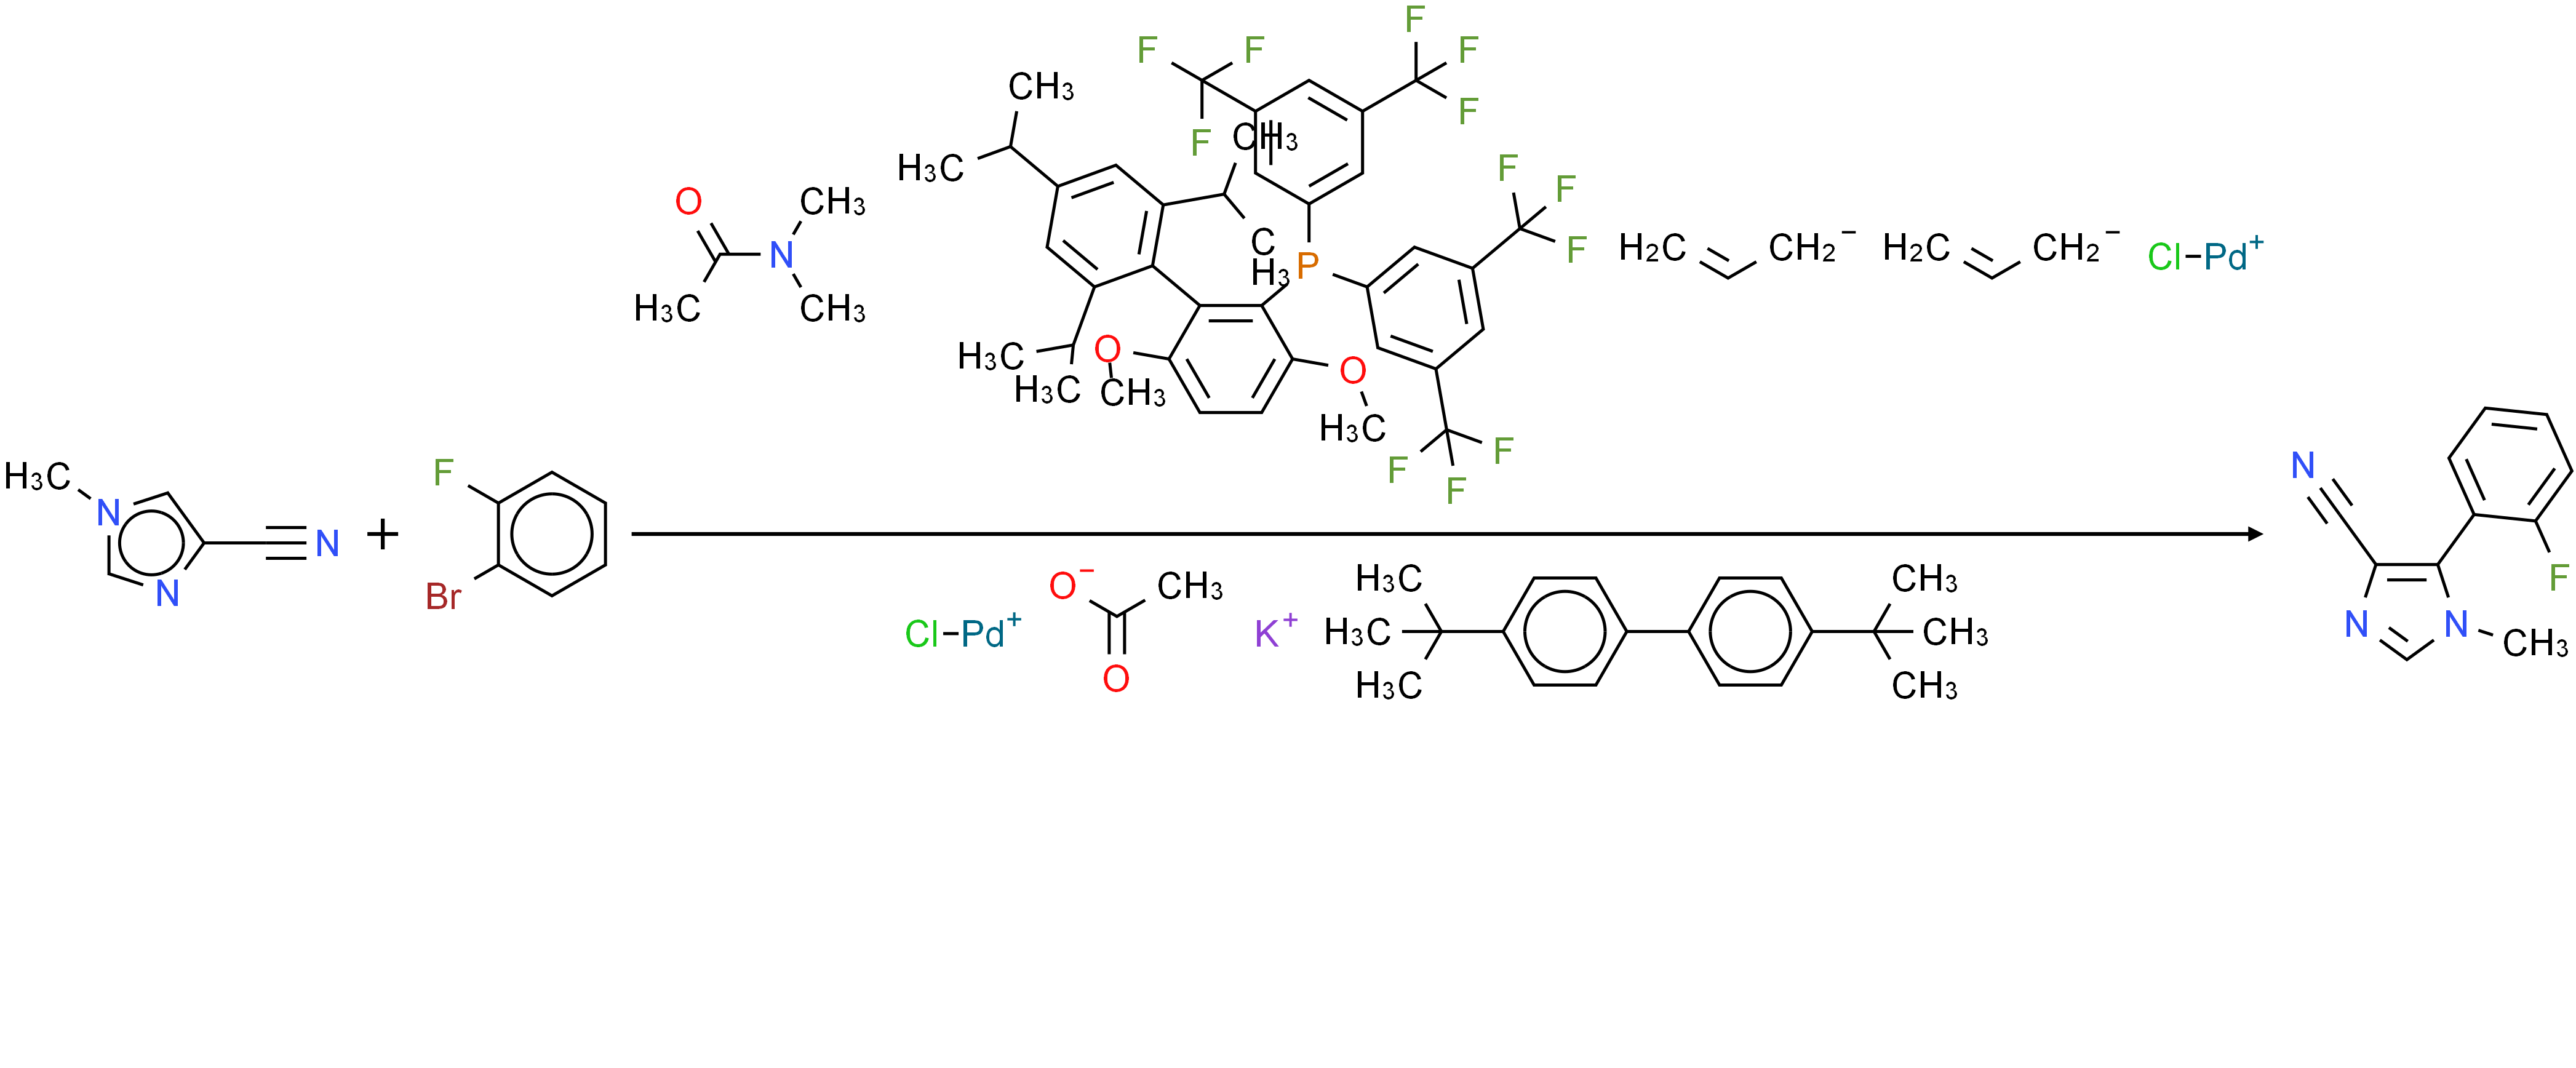

In [224]:
draw_reaction_smi(generate_rxn_smile(all_reactions.loc[rxn_na].iloc[-1005]))

In [9]:
%%time
all_reactions = pd.read_pickle(f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 16.6 s
Wall time: 16.6 s


## Inspect the contents

In [5]:
%%time
all_reactions = pd.read_pickle(f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 18.9 s
Wall time: 18.9 s


## Inspect the contents